# Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# To delete a file

In [ ]:
import os
import shutil

import pandas as pd

In [ ]:
# Path to the directory you want to delete
directory_path = '/content/drive/MyDrive/NXT5/resized/seam_resized2'

# Check if the directory exists before attempting to delete it
if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Deleted directory: {directory_path}")
else:
    print(f"Directory does not exist: {directory_path}")


# To list items in '/content/drive/MyDrive/NXT5/WRB_ready/train

In [ ]:
# from google.colab import drive
# import os

# # # Mount Google Drive
# # drive.mount('/content/drive')

# # Define the path
# directory_path = '/content/drive/MyDrive/NXT5/WRB_ready/train'

# # List all items in the directory
# if os.path.exists(directory_path):
#     items = os.listdir(directory_path)
#     print(f"Items in {directory_path}:")
#     for item in items:
#         print(item)
# else:
#     print(f"Directory does not exist: {directory_path}")

# Moving a single folder

In [ ]:
# Paths for the source and destination folders
source_folder = '/content/drive/MyDrive/WRB sample.xlsx'
destination_folder = '/content/drive/MyDrive/NXT6'

# Create the destination folder if it doesn't already exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
    print("Destination folder created:", destination_folder)
else:
    print("Destination folder already exists:", destination_folder)

# Move the entire folder
try:
    # Check if the source folder actually exists
    if not os.path.exists(source_folder):
        print("The source folder does not exist:", source_folder)
    else:
        # Generate a new path to move the folder into the destination
        final_destination = shutil.move(source_folder, destination_folder)
        print(f"Folder moved from {source_folder} to {final_destination}")
except Exception as e:
    print(f"An error occurred: {e}")

Destination folder created: /content/drive/MyDrive/NXT6
Folder moved from /content/drive/MyDrive/WRB sample.xlsx to /content/drive/MyDrive/NXT6/WRB sample.xlsx


In [ ]:
import os
import pandas as pd
from tabulate import tabulate

In [ ]:
WRB = pd.read_excel('/content/drive/MyDrive/NXT6/WRB sample.xlsx')
print(tabulate(WRB.head(25), headers='keys', tablefmt='psql'))

+----+--------------------------+----------------------+--------------+----------------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | ID                       | Name                 | Group Name   | Project Name   | Label   | 2D Image URL                                                                                                                                              | 2D Image Points                                                 

# Create Directory Structure and Download/Resize Images

In [ ]:
import os
import json
import requests
from PIL import Image
from io import BytesIO
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision.transforms import functional as F
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset

# Load the dataset from Excel
excel_path = '/content/drive/MyDrive/NXT6/WRB sample.xlsx'
dataset = pd.read_excel(excel_path)

# Directory structure
base_dir = '/content/drive/MyDrive/NXT6/WRB'
os.makedirs(base_dir, exist_ok=True)
train_image_dir = os.path.join(base_dir, 'train/images')
train_annotation_dir = os.path.join(base_dir, 'train/annotations')
val_image_dir = os.path.join(base_dir, 'val/images')
val_annotation_dir = os.path.join(base_dir, 'val/annotations')
test_image_dir = os.path.join(base_dir, 'test/images')
test_annotation_dir = os.path.join(base_dir, 'test/annotations')

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_annotation_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_annotation_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(test_annotation_dir, exist_ok=True)

def resize_image_and_boxes(image, boxes, size):
    w, h = image.size
    new_w, new_h = size
    image = F.resize(image, size)

    scale = [new_w / w, new_h / h, new_w / w, new_h / h]
    boxes = [[b[0] * scale[0], b[1] * scale[1], b[2] * scale[2], b[3] * scale[3]] for b in boxes]

    return image, boxes

def save_annotations_and_images(row, image_dir, annotation_dir, size=(800, 800)):
    # Download image
    response = requests.get(row["2D Image URL"])
    img = Image.open(BytesIO(response.content))

    # Resize image and boxes
    points = json.loads(row["2D Image Points"])
    xmin = min(point['x'] for point in points)
    ymin = min(point['y'] for point in points)
    xmax = max(point['x'] for point in points)
    ymax = max(point['y'] for point in points)
    boxes = [[xmin, ymin, xmax, ymax]]
    img, boxes = resize_image_and_boxes(img, boxes, size)

    # Save image
    img_path = os.path.join(image_dir, f'{row["ID"]}.jpg')
    img.save(img_path)

    # Save annotations
    annotations = {
        'boxes': boxes,
        'labels': [1]  # Assuming label "1" for damaged
    }
    annotation_path = os.path.join(annotation_dir, f'{row["ID"]}_bbox.json')
    with open(annotation_path, 'w') as f:
        json.dump(annotations, f)

# Split the data based on "Group Name"
train_data = dataset[dataset["Group Name"] == "Train"]
test_data = dataset[dataset["Group Name"] == "Test"]

# Further split train_data into train (70%), val (20%), test (10%)
train_data, temp_data = train_test_split(train_data, test_size=0.3, random_state=42)
val_data, additional_test_data = train_test_split(temp_data, test_size=1/3, random_state=42)

# Add additional_test_data to test_data
test_data = pd.concat([test_data, additional_test_data])

# Save data to respective folders
for _, row in train_data.iterrows():
    save_annotations_and_images(row, train_image_dir, train_annotation_dir)

for _, row in val_data.iterrows():
    save_annotations_and_images(row, val_image_dir, val_annotation_dir)

for _, row in test_data.iterrows():
    save_annotations_and_images(row, test_image_dir, test_annotation_dir)

print("Dataset preprocessing complete.")


Dataset preprocessing complete.


# Custom Dataset Class

Define a custom dataset class to handle the loading of images and annotations.

In [ ]:
class WRBDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.image_ids = [f.split('.')[0] for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotation_dir, f'{image_id}_bbox.json')

        img = Image.open(img_path).convert("RGB")
        with open(ann_path) as f:
            annotations = json.load(f)

        boxes = torch.as_tensor(annotations['boxes'], dtype=torch.float32)
        labels = torch.as_tensor(annotations['labels'], dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])

        return img, target


## **Data Loader**

Create data loaders for training, validation, and test datasets.

In [ ]:
import torchvision.transforms as T

def get_dataloader(image_dir, annotation_dir, batch_size, shuffle):
    dataset = WRBDataset(image_dir, annotation_dir, transforms=T.ToTensor())
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=lambda x: tuple(zip(*x)))
    return dataloader

train_dataloader = get_dataloader(train_image_dir, train_annotation_dir, batch_size=4, shuffle=True)
val_dataloader = get_dataloader(val_image_dir, val_annotation_dir, batch_size=4, shuffle=False)
test_dataloader = get_dataloader(test_image_dir, test_annotation_dir, batch_size=4, shuffle=False)


# Model Training and Validation

In [ ]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    train_loss = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    return train_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            if isinstance(loss_dict, dict):  # Check if the loss_dict is indeed a dictionary
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()

    return val_loss / len(dataloader)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = get_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

train_losses = []
val_losses = []
learning_rates = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, device)
    val_loss = validate_epoch(model, val_dataloader, device)
    learning_rate = optimizer.param_groups[0]['lr']

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(learning_rate)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Learning Rate: {learning_rate:.6f}")

print("Training complete.")


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 89.1MB/s]


Epoch 1/10, Train Loss: 0.4699, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 2/10, Train Loss: 0.2349, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 3/10, Train Loss: 0.2660, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 4/10, Train Loss: 0.2117, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 5/10, Train Loss: 0.2009, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 6/10, Train Loss: 0.1850, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 7/10, Train Loss: 0.1789, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 8/10, Train Loss: 0.1789, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 9/10, Train Loss: 0.1687, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 10/10, Train Loss: 0.1645, Val Loss: 0.0000, Learning Rate: 0.005000
Training complete.


# Model Evaluation and Visualization

Evaluate the model and visualize the results.

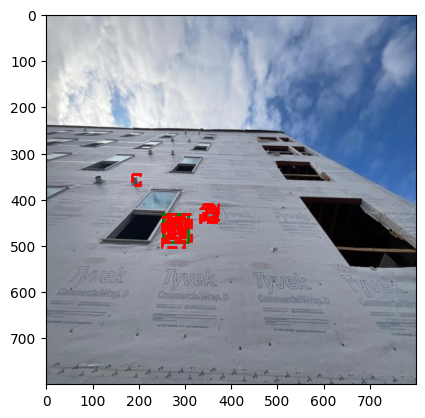

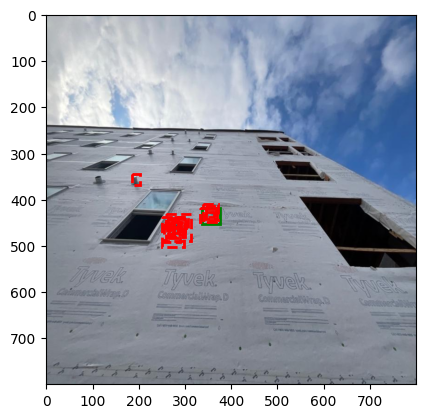

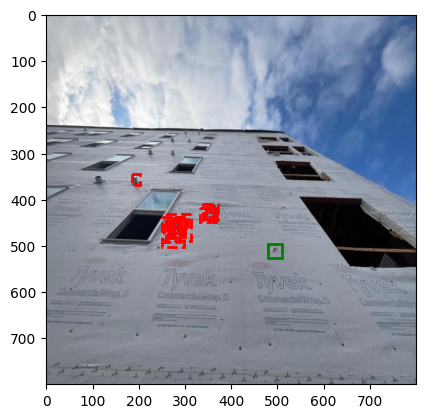

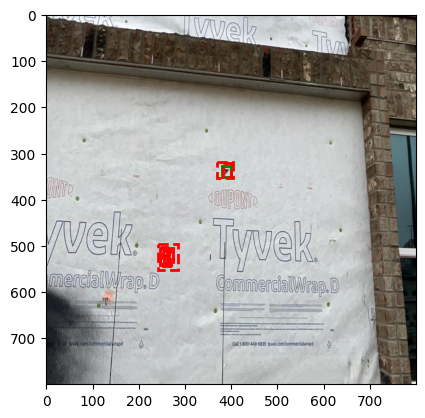

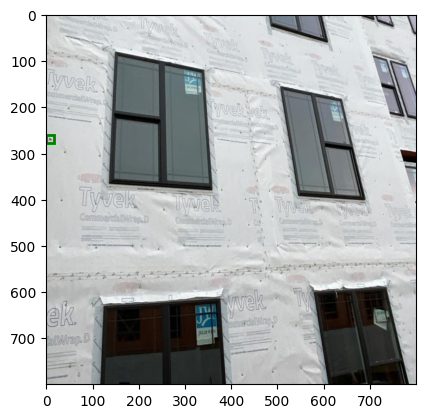

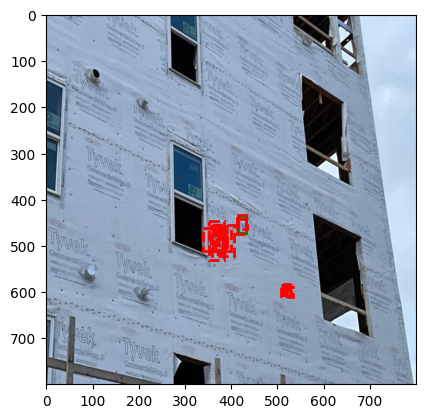

ValueError: Found input variables with inconsistent numbers of samples: [6, 79]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch

def evaluate_model(model, dataloader, device):
    model.eval()
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i, image in enumerate(images):
                true_boxes = targets[i]['boxes'].cpu().numpy()
                pred_boxes = outputs[i]['boxes'].cpu().numpy()

                true_labels = targets[i]['labels'].cpu().numpy()
                pred_labels = outputs[i]['labels'].cpu().numpy()

                all_true_labels.extend(true_labels)
                all_pred_labels.extend(pred_labels)

                fig, ax = plt.subplots(1)
                ax.imshow(image.cpu().permute(1, 2, 0).numpy())

                for box in true_boxes:
                    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='green', facecolor='none')
                    ax.add_patch(rect)

                for box in pred_boxes:
                    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none', linestyle='dashed')
                    ax.add_patch(rect)

                plt.show()

    return all_true_labels, all_pred_labels

def print_metrics(true_labels, pred_labels):
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    accuracy = accuracy_score(true_labels, pred_labels)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# DataLoader for the test dataset
true_labels, pred_labels = evaluate_model(model, test_dataloader, device)
print_metrics(true_labels, pred_labels)


In [3]:
import os
import json
import torch
from matplotlib.animation import FuncAnimation
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as T
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import torchvision.transforms as T
from torch.cuda.amp import GradScaler, autocast

In [4]:
import os

# Define the base directory
base_dir = '/content/drive/MyDrive/NXT6/WRB'
#os.makedirs(base_dir, exist_ok=True)

# Define the paths for training, validation, and test images and annotations
train_image_dir = os.path.join(base_dir, 'train/images')
train_annotation_dir = os.path.join(base_dir, 'train/annotations')
val_image_dir = os.path.join(base_dir, 'val/images')
val_annotation_dir = os.path.join(base_dir, 'val/annotations')
test_image_dir = os.path.join(base_dir, 'test/images')
test_annotation_dir = os.path.join(base_dir, 'test/annotations')

# Custom Dataset Class
Define a custom dataset class to handle the loading of images and annotations.

In [5]:
class WRBDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.image_ids = [f.split('.')[0] for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotation_dir, f'{image_id}_bbox.json')

        img = Image.open(img_path).convert("RGB")
        with open(ann_path) as f:
            annotations = json.load(f)

        boxes = torch.as_tensor(annotations['boxes'], dtype=torch.float32)
        labels = torch.as_tensor(annotations['labels'], dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])

        return img, target

# Data Loader
Create data loaders for training, validation, and test datasets.

In [6]:
import torchvision.transforms as T

def get_dataloader(image_dir, annotation_dir, batch_size, shuffle):
    dataset = WRBDataset(image_dir, annotation_dir, transforms=T.ToTensor())
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=lambda x: tuple(zip(*x)))
    return dataloader

train_dataloader = get_dataloader(train_image_dir, train_annotation_dir, batch_size=4, shuffle=True)
val_dataloader = get_dataloader(val_image_dir, val_annotation_dir, batch_size=4, shuffle=False)
test_dataloader = get_dataloader(test_image_dir, test_annotation_dir, batch_size=4, shuffle=False)


# Model Training and Validation

In [2]:
!pip install torchvision
import torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    train_loss = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    return train_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            if isinstance(loss_dict, dict):  # Check if the loss_dict is indeed a dictionary
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()

    return val_loss / len(dataloader)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = get_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 30

train_losses = []
val_losses = []
learning_rates = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, device)
    val_loss = validate_epoch(model, val_dataloader, device)
    learning_rate = optimizer.param_groups[0]['lr']

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(learning_rate)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Learning Rate: {learning_rate:.6f}")

print("Training complete.")


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 79.0MB/s]


KeyboardInterrupt: 

# Model Evaluation and Visualization
Evaluate the model and visualize the results.

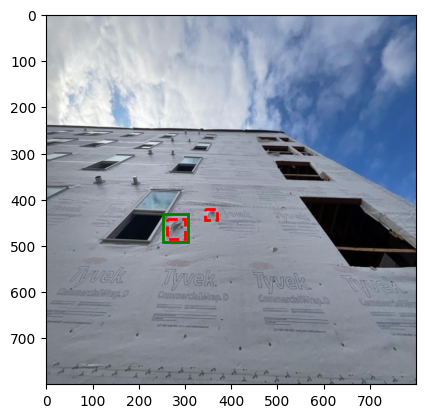

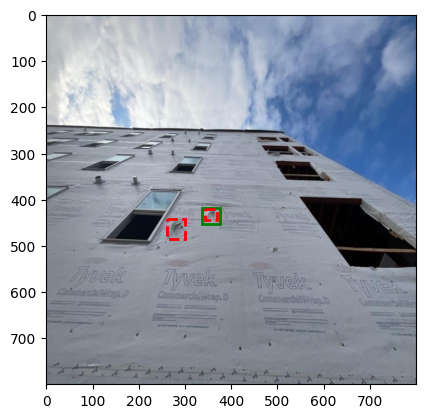

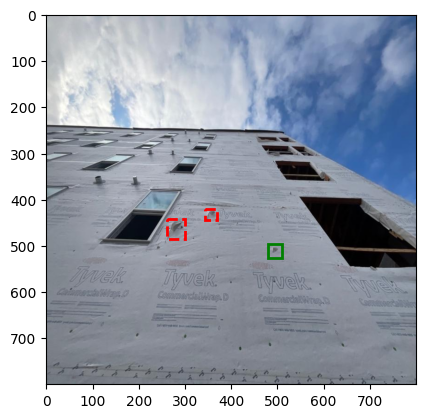

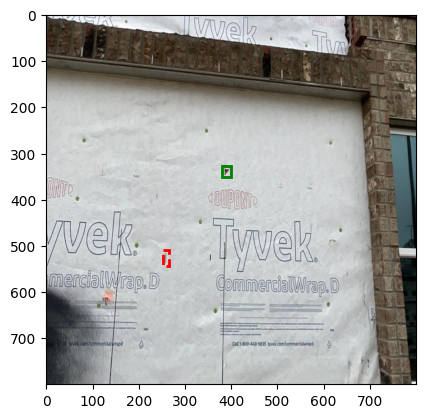

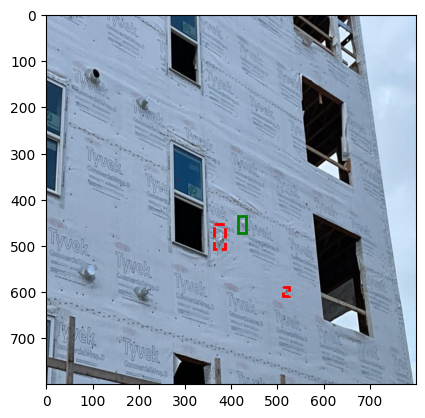

ValueError: Found input variables with inconsistent numbers of samples: [5, 9]

In [ ]:
# Evaluation function (as defined previously)
def evaluate_model(model, dataloader, device, detection_threshold=0.5):
    model.eval()
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i, image in enumerate(images):
                true_boxes = targets[i]['boxes'].cpu().numpy()
                pred_boxes = outputs[i]['boxes'].cpu().numpy()

                true_labels = targets[i]['labels'].cpu().numpy()
                # Only consider predictions with scores above a certain threshold
                pred_scores = outputs[i]['scores'].cpu().numpy()
                pred_labels = outputs[i]['labels'][pred_scores > detection_threshold].cpu().numpy()

                if len(true_labels) > 0 and len(pred_labels) > 0:
                    all_true_labels.extend(true_labels)
                    all_pred_labels.extend(pred_labels)

                    fig, ax = plt.subplots(1)
                    ax.imshow(image.cpu().permute(1, 2, 0).numpy())

                    for box in true_boxes:
                        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='green', facecolor='none')
                        ax.add_patch(rect)

                    for box in pred_boxes[pred_scores > detection_threshold]:
                        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none', linestyle='dashed')
                        ax.add_patch(rect)

                    plt.show()

    return all_true_labels, all_pred_labels

def print_metrics(true_labels, pred_labels):
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    accuracy = accuracy_score(true_labels, pred_labels)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Evaluate the model
true_labels, pred_labels = evaluate_model(model, test_dataloader, device)
print_metrics(true_labels, pred_labels)


# 3rd Run

# Model Training and Validation

In [ ]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    train_loss = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    return train_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            if isinstance(loss_dict, dict):  # Check if the loss_dict is indeed a dictionary
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()

    return val_loss / len(dataloader)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = get_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 50

train_losses = []
val_losses = []
learning_rates = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, device)
    val_loss = validate_epoch(model, val_dataloader, device)
    learning_rate = optimizer.param_groups[0]['lr']

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(learning_rate)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Learning Rate: {learning_rate:.6f}")

print("Training complete.")


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 94.5MB/s]


Epoch 1/50, Train Loss: 0.4362, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 2/50, Train Loss: 0.2217, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 3/50, Train Loss: 0.3138, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 4/50, Train Loss: 0.2370, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 5/50, Train Loss: 0.2174, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 6/50, Train Loss: 0.1888, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 7/50, Train Loss: 0.1764, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 8/50, Train Loss: 0.1628, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 9/50, Train Loss: 0.1691, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 10/50, Train Loss: 0.1604, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 11/50, Train Loss: 0.1426, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 12/50, Train Loss: 0.1487, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 13/50, Train Loss: 0.1413, Val Loss: 0.0000, Learning Rate: 0.005000
Epoch 14/50, Train Loss: 0.1337, V

# Model Evaluation and Visualization

In [ ]:
# Evaluation function (as defined previously)
def evaluate_model(model, dataloader, device, detection_threshold=0.5):
    model.eval()
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i, image in enumerate(images):
                true_boxes = targets[i]['boxes'].cpu().numpy()
                pred_boxes = outputs[i]['boxes'].cpu().numpy()

                true_labels = targets[i]['labels'].cpu().numpy()
                # Only consider predictions with scores above a certain threshold
                pred_scores = outputs[i]['scores'].cpu().numpy()
                pred_labels = outputs[i]['labels'][pred_scores > detection_threshold].cpu().numpy()

                if len(true_labels) > 0 and len(pred_labels) > 0:
                    all_true_labels.extend(true_labels)
                    all_pred_labels.extend(pred_labels)

                    fig, ax = plt.subplots(1)
                    ax.imshow(image.cpu().permute(1, 2, 0).numpy())

                    for box in true_boxes:
                        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='green', facecolor='none')
                        ax.add_patch(rect)

                    for box in pred_boxes[pred_scores > detection_threshold]:
                        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none', linestyle='dashed')
                        ax.add_patch(rect)

                    plt.show()

    return all_true_labels, all_pred_labels

def print_metrics(true_labels, pred_labels):
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    accuracy = accuracy_score(true_labels, pred_labels)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Evaluate the model
true_labels, pred_labels = evaluate_model(model, test_dataloader, device)
print_metrics(true_labels, pred_labels)


NameError: name 'model' is not defined

# 2nd Run

## Imports and Dataset Definition

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
import os
import json
import requests
from PIL import Image
from io import BytesIO
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import optuna
from torch.optim.lr_scheduler import StepLR

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, annotation_dir, transform=None):
        self.df = df
        self.annotation_dir = annotation_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        response = requests.get(row["2D Image URL"])
        img = Image.open(BytesIO(response.content))

        if self.transform:
            img = self.transform(img)

        points = json.loads(row["2D Image Points"])
        xmin = min(point['x'] for point in points)
        ymin = min(point['y'] for point in points)
        xmax = max(point['x'] for point in points)
        ymax = max(point['y'] for point in points)
        boxes = [[xmin, ymin, xmax, ymax]]

        target = {'boxes': torch.tensor(boxes, dtype=torch.float32), 'labels': torch.tensor([1], dtype=torch.int64)}
        return img, target

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomVerticalFlip(0.5))
        transforms.append(T.RandomRotation(30))
        transforms.append(T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2))
    return T.Compose(transforms)

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

def train_epoch(model, dataloader, optimizer, device, scaler):
    model.train()
    train_loss = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += losses.item()

    return train_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            if isinstance(loss_dict, dict):
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()

    return val_loss / len(dataloader)

def evaluate_model(model, dataloader, device):
    model.eval()
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i, image in enumerate(images):
                true_boxes = targets[i]['boxes'].cpu().numpy()
                pred_boxes = outputs[i]['boxes'].cpu().numpy()

                true_labels = targets[i]['labels'].cpu().numpy()
                pred_labels = outputs[i]['labels'].cpu().numpy()

                all_true_labels.extend(true_labels)
                all_pred_labels.extend(pred_labels)

                fig, ax = plt.subplots(1, figsize=(12, 9))
                ax.imshow(image.cpu().permute(1, 2, 0).numpy())

                for box in true_boxes:
                    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth')
                    ax.add_patch(rect)
                    ax.text(box[0], box[1], 'GT', color='green', fontsize=12, va='top')

                for box in pred_boxes:
                    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none', linestyle='dashed', label='Prediction')
                    ax.add_patch(rect)
                    ax.text(box[0], box[1], 'Pred', color='red', fontsize=12, va='top')

                plt.legend(handles=[patches.Patch(color='green', label='Ground Truth'), patches.Patch(color='red', label='Prediction')])
                plt.show()

    return precision_score(all_true_labels, all_pred_labels, average='weighted'), recall_score(all_true_labels, all_pred_labels, average='weighted'), f1_score(all_true_labels, all_pred_labels, average='weighted'), accuracy_score(all_true_labels, all_pred_labels)

def objective(trial, train_dataloader_wrb, val_dataloader_wrb, num_classes,device):
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    momentum = trial.suggest_float('momentum', 0.5, 0.9)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    step_size = trial.suggest_int('step_size', 1, 10)
    gamma = trial.suggest_float('gamma', 0.1, 0.9)

    model = get_model(num_classes)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    scaler = torch.cuda.amp.GradScaler()

    num_epochs = 10
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_dataloader_wrb, optimizer, device, scaler)
        val_loss = validate_epoch(model, val_dataloader_wrb, device)
        scheduler.step()

    val_loss = validate_epoch(model, val_dataloader_wrb, device)
    return val_loss



#  Training and Validation Functions

In [ ]:
def main():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    num_classes = 2

    # Load the WRB dataset
    excel_path_wrb = '/content/drive/MyDrive/NXT6/WRB_sample.xlsx'
    WRB = pd.read_excel(excel_path_wrb)

    # Create new directories
    base_dir_wrb = '/content/drive/MyDrive/NXT6.2/wrb'
    os.makedirs(base_dir_wrb, exist_ok=True)
    train_image_dir_wrb = os.path.join(base_dir_wrb, 'train/images')
    train_annotation_dir_wrb = os.path.join(base_dir_wrb, 'train/annotations')
    val_image_dir_wrb = os.path.join(base_dir_wrb, 'val/images')
    val_annotation_dir_wrb = os.path.join(base_dir_wrb, 'val/annotations')
    test_image_dir_wrb = os.path.join(base_dir_wrb, 'test/images')
    test_annotation_dir_wrb = os.path.join(base_dir_wrb, 'test/annotations')

    os.makedirs(train_image_dir_wrb, exist_ok=True)
    os.makedirs(train_annotation_dir_wrb, exist_ok=True)
    os.makedirs(val_image_dir_wrb, exist_ok=True)
    os.makedirs(val_annotation_dir_wrb, exist_ok=True)
    os.makedirs(test_image_dir_wrb, exist_ok=True)
    os.makedirs(test_annotation_dir_wrb, exist_ok=True)

    # Split data into train, val, test
    train_df_wrb, test_df_wrb = train_test_split(WRB, test_size=0.1, random_state=42)
    train_df_wrb, val_df_wrb = train_test_split(train_df_wrb, test_size=0.2, random_state=42)

    train_dataset_wrb = CustomDataset(train_df_wrb, train_annotation_dir_wrb, transform=get_transform(train=True))
    val_dataset_wrb = CustomDataset(val_df_wrb, val_annotation_dir_wrb, transform=get_transform(train=False))
    test_dataset_wrb = CustomDataset(test_df_wrb, test_annotation_dir_wrb, transform=get_transform(train=False))

    train_dataloader_wrb = DataLoader(train_dataset_wrb, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    val_dataloader_wrb = DataLoader(val_dataset_wrb, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
    test_dataloader_wrb = DataLoader(test_dataset_wrb, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    # Hyperparameter tuning with Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, train_dataloader_wrb, val_dataloader_wrb, num_classes,device), n_trials=50) # Removed extra 'device' argument


    best_trial = study.best_trial
    print(f"Best trial: {best_trial.values}")
    print(f"Best hyperparameters: {best_trial.params}")

    # Training with the best hyperparameters
    best_params = best_trial.params
    best_lr = best_params['lr']
    best_momentum = best_params['momentum']
    best_weight_decay = best_params['weight_decay']
    best_step_size = best_params['step_size']
    best_gamma = best_params['gamma']

    model = get_model(num_classes)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=best_lr, momentum=best_momentum, weight_decay=best_weight_decay)
    scheduler = StepLR(optimizer, step_size=best_step_size, gamma=best_gamma)
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

    num_epochs = 10
    train_losses = []
    val_losses = []
    learning_rates = []

    for epoch in range(num_epochs):
        if scaler:
            train_loss = train_epoch(model, train_dataloader_wrb, optimizer, device, scaler)
        else:
            train_loss = train_epoch(model, train_dataloader_wrb, optimizer, device)

        val_loss = validate_epoch(model, val_dataloader_wrb, device)
        learning_rate = optimizer.param_groups[0]['lr']
        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        learning_rates.append(learning_rate)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Learning Rate: {learning_rate:.6f}")

    print("Training complete.")

    # Evaluate the best model on the test set for WRB
    precision, recall, f1_score, accuracy = evaluate_model(model, test_dataloader_wrb, device)
    print(f"WRB Test Metrics: Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}, Accuracy: {accuracy:.4f}")

    # Save results and visualizations
    results_dir = "/content/drive/MyDrive/NXT6.2/results"
    os.makedirs(results_dir, exist_ok=True)
    test_results_path_wrb = os.path.join(results_dir, "wrb_test_results.json")

    with open(test_results_path_wrb, 'w') as f:
        json.dump({
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
            "accuracy": accuracy
        }, f)

    # Visualize predictions
    model.eval()
    with torch.no_grad():
        for images, targets in test_dataloader_wrb:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i, image in enumerate(images):
                fig, ax = plt.subplots(1, figsize=(12, 9))
                ax.imshow(image.cpu().permute(1, 2, 0).numpy())

                true_boxes = targets[i]['boxes'].cpu().numpy()
                pred_boxes = outputs[i]['boxes'].cpu().numpy()

                for box in true_boxes:
                    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth')
                    ax.add_patch(rect)
                    ax.text(box[0], box[1], 'GT', color='green', fontsize=12, va='top')

                for box in pred_boxes:
                    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none', linestyle='dashed', label='Prediction')
                    ax.add_patch(rect)
                    ax.text(box[0], box[1], 'Pred', color='red', fontsize=12, va='top')

                plt.legend(handles=[patches.Patch(color='green', label='Ground Truth'), patches.Patch(color='red', label='Prediction')])
                plt.show()

    print("Results saved successfully.")

if __name__ == "__main__":
    main()


[I 2024-06-27 17:08:19,627] A new study created in memory with name: no-name-87b23715-d7ea-4368-880f-59592a7d9e2f
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[I 2024-06-27 18:17:10,717] Trial 0 finished with value: 0.0 and parameters: {'lr': 1.0887850804887274e-06, 'momentum': 0.6120571454070971, 'weight_decay': 8.35245803392924e-06, 'step_size': 3, 'gamma': 0.1889082376242387}. Best is trial 0 with value: 0.0.
[I 2024-06-27 19:25:51,930] Trial 1 finished with value: 0.0 and parameters: {'lr': 0.005675704716316203, 'momentum': 0.7567373889807885, 'weight_decay': 4.472045935627798e-06, 'step_size': 8, 'gamma': 0.38449470119933604}. Best is trial 0 with value: 0.0.
[I 2024-06-27 20:34

# Part 3: Evaluation and Saving Results

# Data Preparation

In [ ]:
import os
import json
import requests
from PIL import Image
from io import BytesIO
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
import torch
from torch.utils.data import DataLoader, Dataset

# Resize dimensions
shorter_edge = 256

def resize_image(image):
    aspect_ratio = image.width / image.height
    if aspect_ratio > 1:
        new_width = shorter_edge
        new_height = int(shorter_edge / aspect_ratio)
    else:
        new_height = shorter_edge
        new_width = int(shorter_edge * aspect_ratio)
    return image.resize((new_width, new_height))

class CustomDataset(Dataset):
    def __init__(self, df, annotation_dir, transform=None):
        self.df = df
        self.annotation_dir = annotation_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        response = requests.get(row["2D Image URL"])
        img = Image.open(BytesIO(response.content))
        img = resize_image(img)
        if self.transform:
            img = self.transform(img)
        points = json.loads(row["2D Image Points"])
        xmin = min(point['x'] for point in points)
        ymin = min(point['y'] for point in points)
        xmax = max(point['x'] for point in points)
        ymax = max(point['y'] for point in points)
        boxes = [[xmin, ymin, xmax, ymax]]
        target = {'boxes': torch.tensor(boxes, dtype=torch.float32), 'labels': torch.tensor([1], dtype=torch.int64)}
        return img, target

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomVerticalFlip(0.5))
        transforms.append(T.RandomRotation(30))
        transforms.append(T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2))
    return T.Compose(transforms)


#  Model Training and Validation

In [ ]:
import torchvision
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

def train_epoch(model, dataloader, optimizer, device, scaler):
    model.train()
    train_loss = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += losses.item()
    return train_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            if isinstance(loss_dict, dict):
                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()
    return val_loss / len(dataloader)


# Model Evaluation and Hyperparameter Tuning

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch

def evaluate_model(model, dataloader, device, threshold=0.1):
    model.eval()
    all_true_labels = []
    all_pred_labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            outputs = model(images)
            for i, image in enumerate(images):
                true_boxes = targets[i]['boxes'].cpu().numpy()
                true_labels = targets[i]['labels'].cpu().numpy()
                pred_boxes = outputs[i]['boxes'].cpu().numpy()
                scores = outputs[i]['scores'].cpu().numpy()
                pred_labels = outputs[i]['labels'].cpu().numpy()
                all_true_labels.extend(true_labels)
                high_conf_pred_labels = pred_labels[scores > threshold]
                if high_conf_pred_labels.size > 0:
                    all_pred_labels.extend(high_conf_pred_labels)
                else:
                    all_pred_labels.extend([0] * len(true_labels))
                fig, ax = plt.subplots(1)
                ax.imshow(image.cpu().permute(1, 2, 0).numpy())
                for box in true_boxes:
                    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='green', facecolor='none', label='True')
                    ax.add_patch(rect)
                for box in pred_boxes[scores > threshold]:
                    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none', linestyle='dashed', label='Pred')
                    ax.add_patch(rect)
                handles, labels = ax.get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                ax.legend(by_label.values(), by_label.keys())
                plt.show()
    return all_true_labels, all_pred_labels

def print_metrics(true_labels, pred_labels):
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    accuracy = accuracy_score(true_labels, pred_labels)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

def objective(trial, train_dataloader, val_dataloader, num_classes, device):
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    model = get_model(num_classes)
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params, lr=lr)
    scaler = torch.cuda.amp.GradScaler()
    num_epochs = 5
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_dataloader, optimizer, device, scaler)
        val_loss = validate_epoch(model, val_dataloader, device)
    val_loss = validate_epoch(model, val_dataloader, device)
    return val_loss

def main():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    num_classes = 2
    excel_path = '/content/drive/MyDrive/NXT6/WRB_sample.xlsx'
    df = pd.read_excel(excel_path)
    train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
    train_dataset = CustomDataset(train_df, 'annotations', transform=get_transform(train=True))
    val_dataset = CustomDataset(val_df, 'annotations', transform=get_transform(train=False))
    test_dataset = CustomDataset(test_df, 'annotations', transform=get_transform(train=False))
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
    test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    # Hyperparameter tuning with Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, train_dataloader, val_dataloader, num_classes, device), n_trials=10)
    best_trial = study.best_trial
    print(f"Best trial: {best_trial.values}")
    print(f"Best hyperparameters: {best_trial.params}")

    # Training with the best hyperparameters
    best_params = best_trial.params
    best_lr = best_params['lr']

    model = get_model(num_classes)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params, lr=best_lr)
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

    num_epochs = 5
    for epoch in range(num_epochs):
        if scaler:
            train_loss = train_epoch(model, train_dataloader, optimizer, device, scaler)
        else:
            train_loss = train_epoch(model, train_dataloader, optimizer, device)
        val_loss = validate_epoch(model, val_dataloader, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    print("Training complete.")

    # Evaluate the model on the test set
    true_labels, pred_labels = evaluate_model(model, test_dataloader, device, threshold=0.1)
    print(len(true_labels))
    print(len(pred_labels))
    print_metrics(true_labels, pred_labels)

if __name__ == "__main__":
    main()
